<a href="https://colab.research.google.com/github/KC-Night/pca_assignment/blob/main/assignment_(7).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## PCA and Text Analysis

This assignment involves processing real e-mails, some of which are scams.

Fair warning: Some of these scam e-mails have offensive content. If you start reading the e-mail text or the token data, you might read something offensive. If that's a problem, feel free to e-mail me, and we can talk about it and discuss how to proceed with alternative tasks.

In [1]:
!git clone https://github.com/KC-Night/pca_assignment.git

Cloning into 'pca_assignment'...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (2/2), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 9 (delta 0), reused 0 (delta 0), pack-reused 7 (from 1)
Receiving objects: 100% (9/9), 1.54 MiB | 6.17 MiB/s, done.


### Q1.

**Tokens**: The individual words or symbols that create text data like emails. Natural Language Processing is primarily about analyzing the frequency and co-occurrence of tokens.

I aggregated all the emails into a single vector, and removed the punctuation and very common words (e.g. "the"). Run the below code chunk to open it, and use the Counter class to look at the most common words:

In [2]:
import pickle
with open('./pca_assignment/data/all_tokens.pickle', 'rb') as file:
    all_tokens = pickle.load(file)

from collections import Counter
token_count = Counter(all_tokens)
token_freq = token_count.most_common()

In [3]:
token_freq[:10]

[('new', 1365),
 ('date', 1202),
 ('get', 1052),
 ('please', 1022),
 ('enron', 927),
 ('like', 923),
 ('2002', 869),
 ('would', 806),
 ('one', 798),
 ('message', 795)]

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

Plot a histogram of the occurrences of tokens.

What do you notice about the frequency of occurrence of different tokens? How does it look?

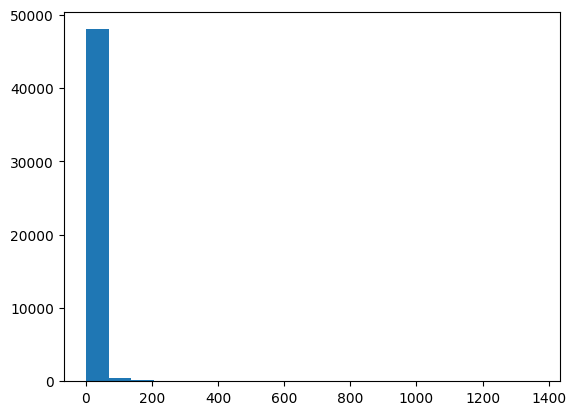

In [24]:
plt.hist(token_count.values(), bins=20)
plt.show()

In [25]:
# The histogram is very right skewed, and the frequency of occurance of different tokens tends to be that a few words appear in most emails, and most words appear in very few emails.

### Q2.

Load `Phishing_clean.parquet`. This is the text from the e-mails broken into the most common 2,711 tokens and one-hot-encoded as features/covariates. So each row is an e-mail, the `Email Type` takes the value 1 if it's a scam and 0 otherwise, and every other column is a word or symbol that occurs in at least 15 e-mails.

1. Perform an 80/20 train-test split of the data.
2. Run a regression of $y$ on the one-hot-encoded emails. What is the $R^2$ on the test set? On the training set?
3. What words have the largest coefficients in absolute value and most strongly influence predictions?

In [5]:
phis_df= pd.read_parquet('./pca_assignment/data/Phishing_clean.parquet')
phis_df.head()

,Email Type,new,date,get,please,enron,like,2002,would,one,...,ï¿½ï¿½,safety,yap,ypil,maintain,procedures,tip,elizabeth,leadership,italian
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
from sklearn.model_selection import train_test_split

# 80/20 train test split
x_train, x_test, y_train, y_test = train_test_split(phis_df.drop(columns=['Email Type']), phis_df['Email Type'], test_size=0.2, random_state=42)

In [7]:
from sklearn.linear_model import LinearRegression

# regression of y
reg = LinearRegression().fit(x_train, y_train)

In [8]:
print(reg.score(x_train, y_train)) #R^2 train set
print(reg.score(x_test, y_test)) #R^2 test set

0.7670143724934355
0.6658718438847919


In [9]:
coefficients = reg.coef_ #array, token per word
features = x_train.columns # token names

coef_df= pd.DataFrame({'Feature': features, 'Coefficient': coefficients}) # extract coefficients and put into dataframe
coef_df['Coefficient_Abs'] = coef_df['Coefficient'].abs() # rank by absolute value

coef_df.sort_values(by='Coefficient_Abs', ascending=False, inplace=True) #sort values of dataframe
coef_df.head()

# intervention, localized, thermal, crawler, and background-image has the largest coefficient in absolute value

,Feature,Coefficient,Coefficient_Abs
835,intervention,-1.259257,1.259257
740,localized,0.824350,0.824350
2362,thermal,0.747006,0.747006
851,crawler,0.696167,0.696167
1504,background-image:,-0.622909,0.622909


### Q3.

Take the matrix of one-hot-encoded tokens (the data, less the outcome variable, `Email Type`) and perform a principal components analysis decomposition with two components. Plot the first two principal components in a scatter plot, and hue the points by whether they are a phishing scam or not. Do you notice any patterns?

In [10]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=42)
pca.fit(x_train)
x_train_pca = pca.transform(x_train)
x_test_pca = pca.transform(x_test)

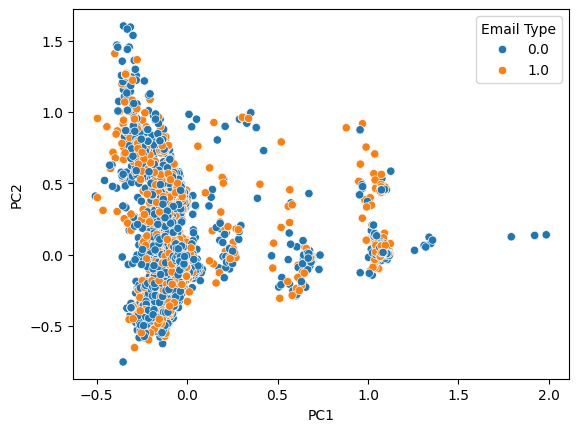

In [11]:
pca_df = pd.DataFrame(x_train_pca, columns=['PC1', 'PC2'])
pca_df['Email Type'] = y_train

import seaborn as sns
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Email Type')
plt.show()

In [12]:
# The points are mixed together, meaning many non-scam and scam emails share many of the same tokens.

### Q4.

Run a linear regression of $y$ on the first 2,610 principal components of $X$. What is the $R^2$ on the training and test sets? (I used cross validation to determine that 2,610 was approximately optimal, but not all 2,711 components.)

How does this performance compare to the linear regression?

In [13]:
pca2 = PCA(n_components=2610, random_state=42)
x_train_pca2 = pca2.fit_transform(x_train)
x_test_pca2 = pca2.transform(x_test)

In [18]:
reg2 = LinearRegression().fit(x_train_pca2, y_train)
y_pred_train = reg2.predict(x_train_pca2)
y_pred_test = reg2.predict(x_test_pca2)

In [19]:
print(reg2.score(x_train_pca2, y_train)) #R^2 train set
print(reg2.score(x_test_pca2, y_test)) #R^2 test set

0.7662326827745849
0.6683390643101164


In [20]:
# The performance is very similar to the linear regression. That's possibly because we only dropped around 100 values, which means the variation in the dataset is about the same

### Q5.

Explain briefly in your own words what the advantage is in using the principal components to run this high-dimensional regression, rather than the original data.

In [21]:
# Using PCA reduces dimensionality and multicollinearity, creating a more stable model that allows us to get higher quality results